# Easy Explain in details

Easy explain uses under the hood [Captum](https://captum.ai/). Captum aids to comprehend how the data properties impact the model predictions or neuron activations, offering insights on how the model performs. Captum comes together with [Pytorch library](https://pytorch.org/). Currently Easy Explain is working only for images and only for Pytorch.

Captum allows for the unified application of several different cutting-edge feature attribution techniques, such as Guided GradCam and Integrated Gradients. In addition the Occlusion methodology is being used.

### How does Occlusion work?

Attribution can be calculated using a perturbation-based method by first replacing all adjacent rectangular regions with a particular baseline/reference and then calculating the change in output. Features spread over many hyperrectangles have their attributions calculated by averaging the differences in output from each hyperrectangle.

The initial patch is applied such that its corner is aligned with all zeros in the index range, and subsequent patches are applied in steps until the full dimension range has been patched. Keep in mind that this might lead to the final patch applied in a direction being smaller than the intended occlusion form due to being cut off.

This [paper](https://arxiv.org/abs/1311.2901) can help for more details.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from io import BytesIO
import requests
import numpy as np
from captum.attr import visualization as viz
from captum.attr import Occlusion
import json

### Step by step implementation and explanations

Let's load our model. We will use the Resnet50 from torchvision models

In [3]:
model = torchvision.models.resnet50(pretrained=True).eval()

Let's get our image. We will get an image from [Unsplash](https://unsplash.com)

In [4]:
response = requests.get("https://unsplash.com/photos/ZxNKxnR32Ng/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8NHx8bGlvbnxlbnwwfHx8fDE2NzU3OTY5NjE&force=true")
image = Image.open(BytesIO(response.content))

Let's do a classical processing for our image

In [5]:
def process_image(image):
    center_crop = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        ])

    normalize = transforms.Compose([
        # convert the image to a tensor with values between 0 and 1
        transforms.ToTensor(), 
        # normalize to follow 0-centered imagenet pixel rgb distribution              
        transforms.Normalize(                
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
        ])
    return normalize(center_crop(image)).unsqueeze(0)

For this notebook we use the presaved example labels that Resnet50 has used during it's training phase

In [6]:
def load_data_labels(path: str =  'imagenet_class_index.json'):
    # Opening JSON file
    f = open(path)
    # returns JSON object as 
    # a dictionary
    data = json.load(f)

    return data

In order to **explain** our results we have to know for which classes we want to have the explanation. So we need firslt to predict the needed classes.

For this notebook we will explain the first one. In general someone can have her own defined class to explain. But have in mind that the first one classes have a sense to be explained.

For example if we have an image of a dog, we do not want to know why the model said that maybe our image represents a shark for a percentage of 0.005%.

So, as you guessed through the below function we also extract the percentages.

In [7]:
def predict_classes(input_img, labels, model, total_preds:int=5):
    # Find the score in terms of percentage by using torch.nn.functional.softmax function
    # which normalizes the output to range [0,1] and multiplying by 100
    out = model(input_img)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    # Find the index (tensor) corresponding to the maximum score in the out tensor.
    # Torch.max function can be used to find the information
    _, indices = torch.sort(out, descending=True)
    prediction = [(idx.item(), labels[str(idx.item())][1], percentage[idx].item()) for idx in indices[0][:total_preds]]
    
    return prediction

Here we have the main functionality of Occlusion. As a target we use the class we want to have the explanation (as stated above). 

Maybe we want to check the second or third in the row prediction. Keep in mind that each time we can explain only one of the categories.

The important parts here are:

- strides: For each iteration, this specifies how far the occlusion hyperrectangle should be adjusted in each direction. This may be a single integer that is used as the step size in each direction for a single tensor input, or it can be a tuple of numbers that corresponds to the number of dimensions in the occlusion form.
- baselines: They define reference value which replaces each feature when occluded
- sliding_window_shapes: Shape of patch (hyperrectangle) to occlude each input.

For more information please read [Captum's Occlusion Docs](https://captum.ai/api/occlusion.html)

In [8]:
def create_attribution(target, model, input_img):
    occlusion = Occlusion(model)
    strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
    sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
    baselines = 0                     # values to occlude the image with. 0 corresponds to gray
    attribution = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)
    
    trans_attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))

    return trans_attribution

A simple function to get the prediction name (we need it only for the title of the plots)

In [9]:
def get_prediction_name_from_predictions(predictions):
    name_of_prediction = predictions[0][1]
    name_of_prediction = name_of_prediction.capitalize().replace('_', ' ')
    return name_of_prediction

A helpful function to construct the titles of our images

In [10]:
def get_image_titles(vis_types, vis_signs, name_of_prediction):
    image_titles_list = []
    for i in range(len(vis_types)):

        if vis_signs[i]!="all":
            title = vis_types[i].capitalize().replace('_', ' ') + " for " + name_of_prediction
        else:
            title = vis_signs[i].capitalize().replace('_', ' ') + " " + vis_types[i].capitalize().replace('_', ' ') + " for " + name_of_prediction
        image_titles_list.append(title)
    return image_titles_list

Our function that will visualize the results. There are several combinations for vis_types and vis_signs. you can play a bit with them.

In [11]:
def create_explanation(attribution, image, name_of_prediction, vis_types=[["blended_heat_map", "original_image"]], vis_signs = [["all", "all"]]):
    center_crop = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        ])
    image_titles_list = get_image_titles(vis_types, vis_signs, name_of_prediction)
    _ = viz.visualize_image_attr_multiple(attribution,
                                      np.array(center_crop(image)),
                                      vis_types,
                                      vis_signs,
                                      image_titles_list,
                                      show_colorbar = True
                                     )

### Results

Let's run all the above fucntions together

In [12]:
labels = load_data_labels() 
input_img = process_image(image)
prediction = predict_classes(input_img, labels, model, 5)
prediction_name = get_prediction_name_from_predictions(prediction)
trans_attribution = create_attribution(prediction[0][0], model, input_img)

The main 5 predictions are:

In [13]:
prediction

[(291, 'lion', 99.32210540771484),
 (260, 'chow', 0.3969624638557434),
 (292, 'tiger', 0.06366979330778122),
 (286, 'cougar', 0.027550136670470238),
 (244, 'Tibetan_mastiff', 0.0227434653788805)]

The model is pretty sure about the lion class. Let's see the explanations...

(We will use separated parts for each explanation, each time only one set, eg. "blended_heat_map", "original_image")

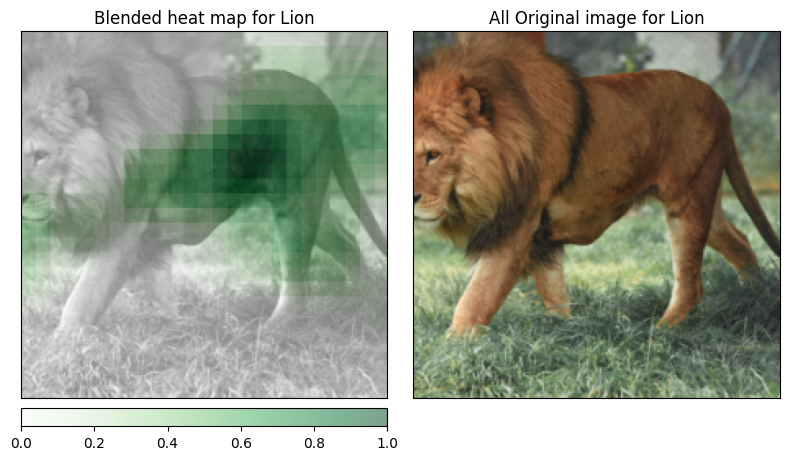

In [14]:
vis_types=[["blended_heat_map", "original_image"]]
vis_signs = [["positive","all"]]
number_of_sets = len(vis_types)

for i in range(number_of_sets):
    create_explanation(trans_attribution, image, prediction_name, vis_types = vis_types[i], vis_signs=vis_signs[i])

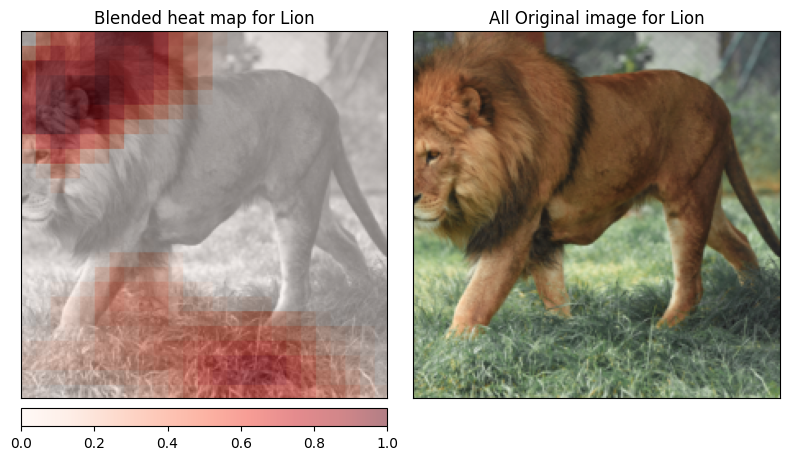

In [15]:
vis_types=[["blended_heat_map", "original_image"]]
vis_signs = [["negative","all"]]
number_of_sets = len(vis_types)

for i in range(number_of_sets):
    create_explanation(trans_attribution, image, prediction_name, vis_types = vis_types[i], vis_signs=vis_signs[i])

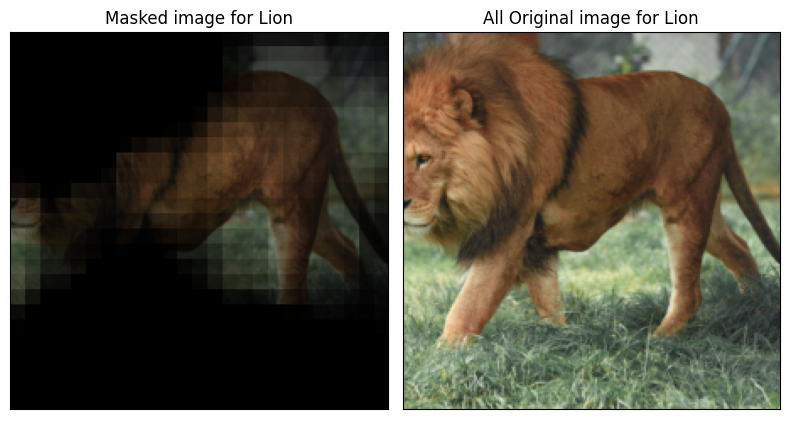

In [16]:
vis_types=[["masked_image", "original_image"]]
vis_signs = [["positive","all"]]
number_of_sets = len(vis_types)

for i in range(number_of_sets):
    create_explanation(trans_attribution, image, prediction_name, vis_types = vis_types[i], vis_signs=vis_signs[i])

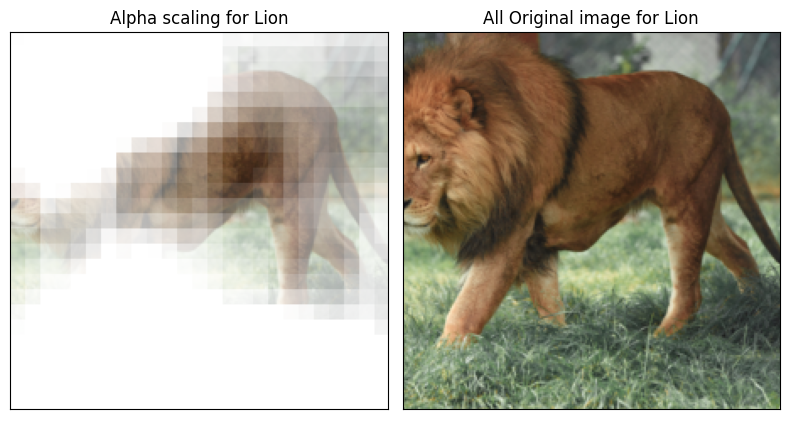

In [17]:
vis_types=[["alpha_scaling", "original_image"]]
vis_signs = [["positive","all"]]
number_of_sets = len(vis_types)

for i in range(number_of_sets):
    create_explanation(trans_attribution, image, prediction_name, vis_types = vis_types[i], vis_signs=vis_signs[i])

Through the above visualisations we can understand some main parts that our model "has seen" and dicided that the image includes a lion. So some of these parts are the mouth, the mid part and the legs. 

The upper head of the lion and the ground were the parts that it thought the opposite.
The ground should not play a major role to the selection since it does not help to conlcude about the image. This is based on the training set and inserts some bias into our model.

So, let's have a one more try. This time we will go for the next predicted class:

In [19]:
input_img = process_image(image)
prediction = predict_classes(input_img, labels, model, 5)
prediction = prediction[1:]
prediction_name = get_prediction_name_from_predictions(prediction)
trans_attribution = create_attribution(prediction[0][0], model, input_img)

The prediction now is:

In [20]:
prediction

[(260, 'chow', 0.3969624638557434),
 (292, 'tiger', 0.06366979330778122),
 (286, 'cougar', 0.027550136670470238),
 (244, 'Tibetan_mastiff', 0.0227434653788805)]

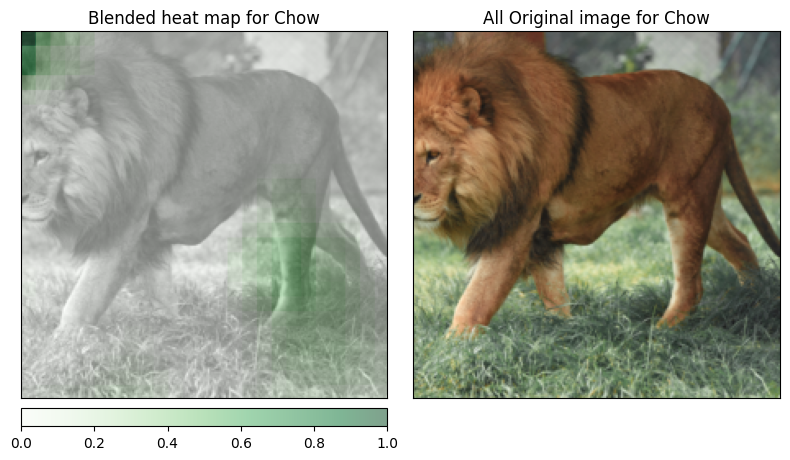

In [21]:
vis_types=[["blended_heat_map", "original_image"]]
vis_signs = [["positive","all"]]

number_of_sets = len(vis_types)

for i in range(number_of_sets):
    create_explanation(trans_attribution, image, prediction_name, vis_types = vis_types[i], vis_signs=vis_signs[i])

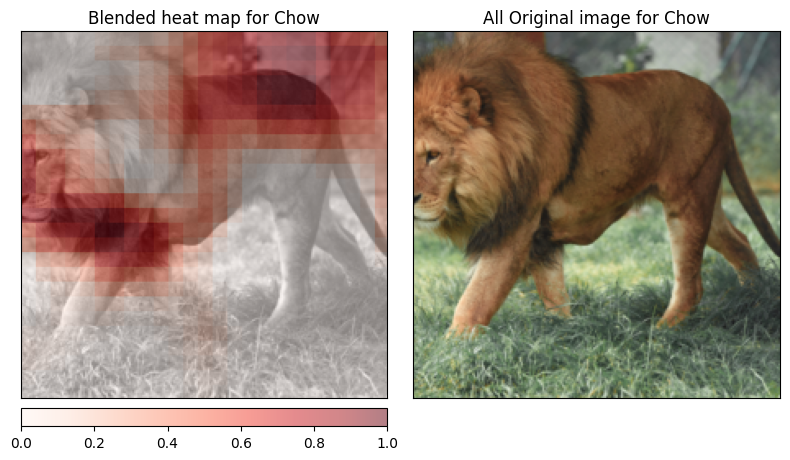

In [22]:
vis_types=[["blended_heat_map", "original_image"]]
vis_signs = [["negative","all"]]
number_of_sets = len(vis_types)

for i in range(number_of_sets):
    create_explanation(trans_attribution, image, prediction_name, vis_types = vis_types[i], vis_signs=vis_signs[i])

Mainly the legs of the animal led the model to believe that for 0.40% the image represented a chow.